# Project: Analysis of birth rate decline and selected factors

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions and Limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction
> In this project I would like to analyse factors which may have played role in declining birth rates. I will use datasets from Gapminder. My main interest variable is birth per woman. For possible independent variables I consider child mortality under age 5, gdp per capita (in 2017 prices), labor force participation rates of women aged 15-64 and mean schooling of females aged 25-34.
> Perliminary, one would expect following association regarding chosen variables and birth per woman:
> 1. High child mortality would push woman to give more birth to copmensate for possible risks. So decrease in mortality should motivate to decrease birth per woman.
> 2. Schooling increases the age of marriage and knowledge on family planning in favor of restricted number of children per woman.
> 3. Greater labor partiticpation increases the value of time for woman. It would be much more expensive to allocate time for chilbearing.
> 4. Greater income (GDP per capita) would increase birth per woman, since people could afford to rear more children.

### Questions for analysis
> 1. What factors more contributed to declining birth rates?
> 2. Does schooling decrease fertility?

Loading main packages and plot style.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

<a id='wrangling'></a>
## Data Wrangling

> Each variable is downloaded from Gapminder seprately in 'csv' format. Since each datasets have columns as country and year, we need to stack them and create a dataset which has 3 columns [country name, year and variable]. To avoid repetition I created a function which does stacking and renaming of columns. I will check on the shape and merge them into one whole dataset. When merging I will make sure there is no null values for any observation. I will trim data to period 1990-2020. Below is the code for loading, reshaping and trimming the data. 

### General Properties

In [2]:
# Loading data for each variable
df = pd.read_csv('children_per_woman_total_fertility.csv')
df_c = pd.read_csv('child_mortality_0_5_year_olds_dying_per_1000_born.csv')
df_l = pd.read_csv('females_aged_15_64_labour_force_participation_rate_percent.csv')
df_gdp = pd.read_csv('income_per_person_gdppercapita_ppp_inflation_adjusted.csv')
df_ed = pd.read_csv('mean_years_in_school_women_25_to_34_years.csv')

In [3]:
## creating a function which stacks every data and renames the columns as [country, year and respective variable]
def df_stack(df, colname):
    df = df.set_index('country').stack().reset_index()
    df.columns = ['country', 'year', colname]
    return df

In [4]:
# Applying function for each dataset
df = df_stack(df, 'birthrt')
df_c = df_stack(df_c, 'c_mrtlty')
df_l = df_stack(df_l, 'lbr_prt')
df_gdp = df_stack(df_gdp, 'gdppc')
df_ed = df_stack(df_ed, 'schooling')

Checking each dataset's size. Eventually we need to match the size when we merge them all. In fact, observation numbers differ.

In [5]:
datasets = [df, df_c, df_l, df_gdp, df_ed]
for d in datasets: print(d.shape)

(60715, 3)
(57497, 3)
(5670, 3)
(48945, 3)
(8648, 3)


Now, I merge them using 'inner' choice, which means all datasets are merged if they have data on common merging columns [country, year]. As a result I have a dataset which has 4680 rows and 7 columns. There will be no NaN values, since the merging command chooses only observations with full information on all columns. We could manipulate data with using means or medians for the observations which lack data, however in this case it is not appropriate because observation differ in time and accros countries. 

In [6]:
### Merging
for d in datasets[1:]:
  df = df.merge(d, how ='inner')
print("Total observations and columns: {}".format(df.shape))
print("Total observations with null values: {}".format(df.isnull().sum().sum()))

Total observations and columns: (4680, 7)
Total observations with null values: 0


Converting year into integer and trimming data to period after year 1990.

In [7]:
### Convert int year to integer and trimming data to 1990-2020 period
df['year'] = df['year'].astype(int)
df = df[df.year>=1990]

GDP pc columns is in string format. I convert it to float format. However, values over 1000 are written in abbreviated format with letter k as the ending. For example, 10 000 is written as 10K. I replaced them accordingly to get final value in terms of float numbers.

In [8]:
## Converting GDP per capital values to float.
df['gdppc'] = df['gdppc'].str.replace(",", "")
df['gdppc'] = df['gdppc'].str.replace("k", "00")
df['gdppc'] = df['gdppc'].astype(float)

As a final product I have dataset with 4500 observations total observations for 180 countries with each country providing 25 values for each year. Our dataset is for 1990-2014, since not all values were provided in datasets for periods after 2014.

In [9]:
df.describe(include='all')

,country,year,birthrt,c_mrtlty,lbr_prt,gdppc,schooling
count,4500,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
unique,180,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN
freq,25,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2002.000000,3.290449,52.402971,55.221049,2392.291289,8.286671
std,NaN,7.211904,1.732815,54.828114,17.688149,2797.755490,3.921395
min,NaN,1990.000000,0.900000,2.180000,6.280000,10.100000,0.430000
25%,NaN,1996.000000,1.810000,11.000000,44.900000,31.475000,5.020000
50%,NaN,2002.000000,2.740000,28.300000,57.450000,1480.000000,8.760000
75%,NaN,2008.000000,4.680000,81.300000,67.900000,3930.000000,11.600000


<a id='eda'></a>
## Exploratory Data Analysis

> Our main interest in exploring factors behind declining birth rates. 

### Research Question 1 (What factors more contributed to declining birth rates?)

>First, lets establish overall trend of birth rates. The boxplot (Figure 1) provided below shows that birth rates declined very steeply. Values of maximum, median and even outliers show significant visual decline. The decline looks most happened in the 90s. Apart from declining, the range of birth rates also narrowed, showing that disregarding any difference in countries, their birth rate difference is also decreasing. Birth rate on median looks like settling on population-replacement ratio (2.1 per woman).

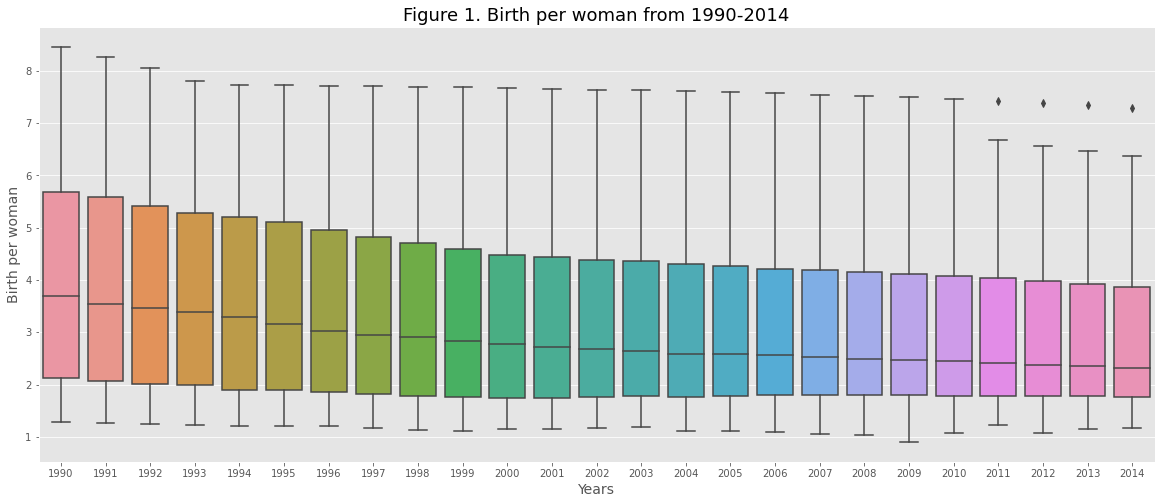

In [10]:
plt.figure(figsize = (20,8))
sns.boxplot(x='year', y='birthrt', data=df)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Birth per woman', fontsize=14)
plt.title('Figure 1. Birth per woman from 1990-2014', fontsize = 18)
plt.show()

To see association between variables and the birth per woman I can look at scatterplots. However, since we have 25 points for each country, my plot might look very crowded. So I can decide to choose one year and plot scatter plots for this year. I use year 2000, because this is the year when decline of birth rates looks like settled down from steep declining trend of 90s.

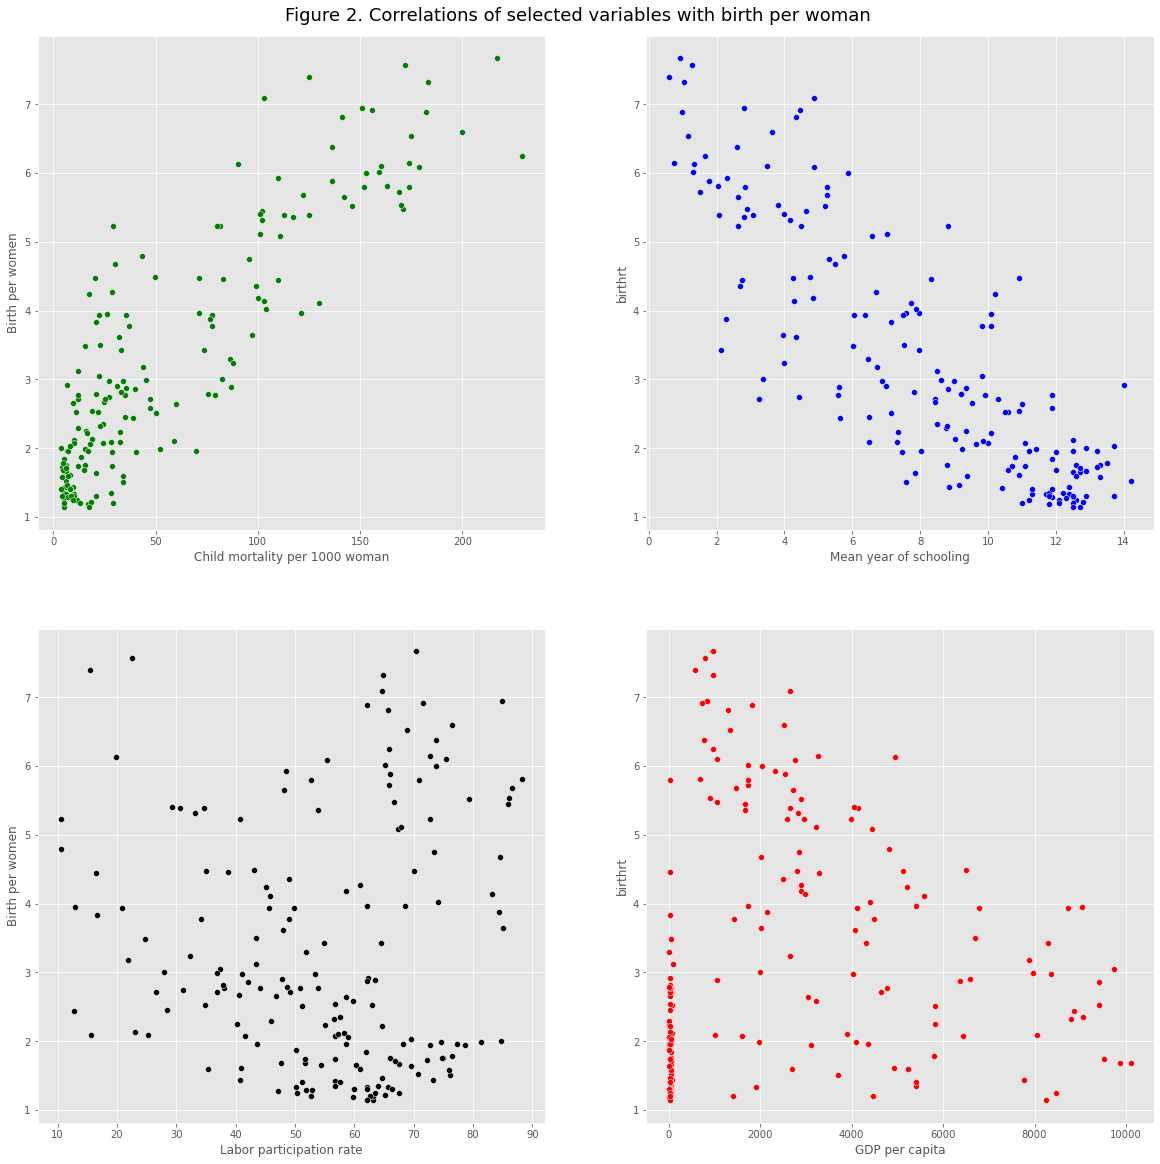

In [11]:
## Birth rate and variables correlation
df_2000 = df[df.year==2000]
fig, axes = plt.subplots(2,2, figsize=(20,20))
fig.suptitle('Figure 2. Correlations of selected variables with birth per woman', fontsize = 18, y=0.90)

sns.scatterplot(x='c_mrtlty', y='birthrt', color='green', data=df_2000, ax =axes[0,0])
sns.scatterplot(x='schooling', y='birthrt', color='blue', data=df_2000, ax =axes[0,1])
sns.scatterplot(x='lbr_prt', y='birthrt', color='black', data=df_2000, ax =axes[1,0])
sns.scatterplot(x='gdppc', y='birthrt', color='red', data=df_2000, ax =axes[1,1])

axes[0, 0].set(xlabel = 'Child mortality per 1000 woman', ylabel = 'Birth per women')
axes[0, 1].set(xlabel = 'Mean year of schooling')
axes[1, 0].set(xlabel = 'Labor participation rate', ylabel = 'Birth per women')
axes[1, 1].set(xlabel = 'GDP per capita')

plt.show()

Figure 2, shows that birth per woman has positive association with child mortality and negative association with schooling. There is also some weak negative association with income (GDP per capita). Interstingly, labor participation of woman has no visible association, although it would be plausible to expect a negative association.

Since we are looking at the point of time, comparing countries might not be correct. Because every country have different social setting regarding birth not captured by above variables. However, in this case we could compare association of relative changes within the same country. For example, we can look at changes in income and compare it with changes in birth rates. Let's see associations in terms of changes within a decade from year 1990 to year 2000.

Below code divides data sets by two years and calculates percentage change of each variable from year 1990 to year 2000. I also added suffix '_year' to each column indicating they are the values for the year chosen (1990 or 2000). two year datasets were merged into one. I calculate differnece in log values for each observation, because difference in log values produce rough estimate of percentage changes.

In [12]:
df_1990 = df[df.year==1990].drop(columns = 'year')
df_2000 = df[df.year==2000].drop(columns = 'year')
## renaming columns
colnames_1990 = ['country']
colnames_2000 = ['country']
for col in ['birthrt', 'c_mrtlty', 'lbr_prt', 'gdppc', 'schooling']:
     colnames_1990.append(col+'_1990')
     colnames_2000.append(col+'_2000')
df_1990.columns = colnames_1990
df_2000.columns = colnames_2000
df_n = df_1990.merge(df_2000, how='inner')

In [13]:
### Function to calculate percentage change from 1990 to 2000 (difference in log values)
def d_change(df, colname):
    y1 = colname + '_2000'
    y2 = colname + '_1990'
    d = np.log(df[y1]) - np.log(df[y2])
    return d

In [14]:
### Applying function to create columns of respective changes for each variable
variables = ['birthrt', 'c_mrtlty', 'lbr_prt', 'gdppc', 'schooling']
for d in variables:
    df_n['d_'+ d] = d_change(df_n, d)

Now our new data set df_n contains data on percentage change for each variable for each country. We can plot scatter plot of changes agains change sin birth per woman (Figure 3).

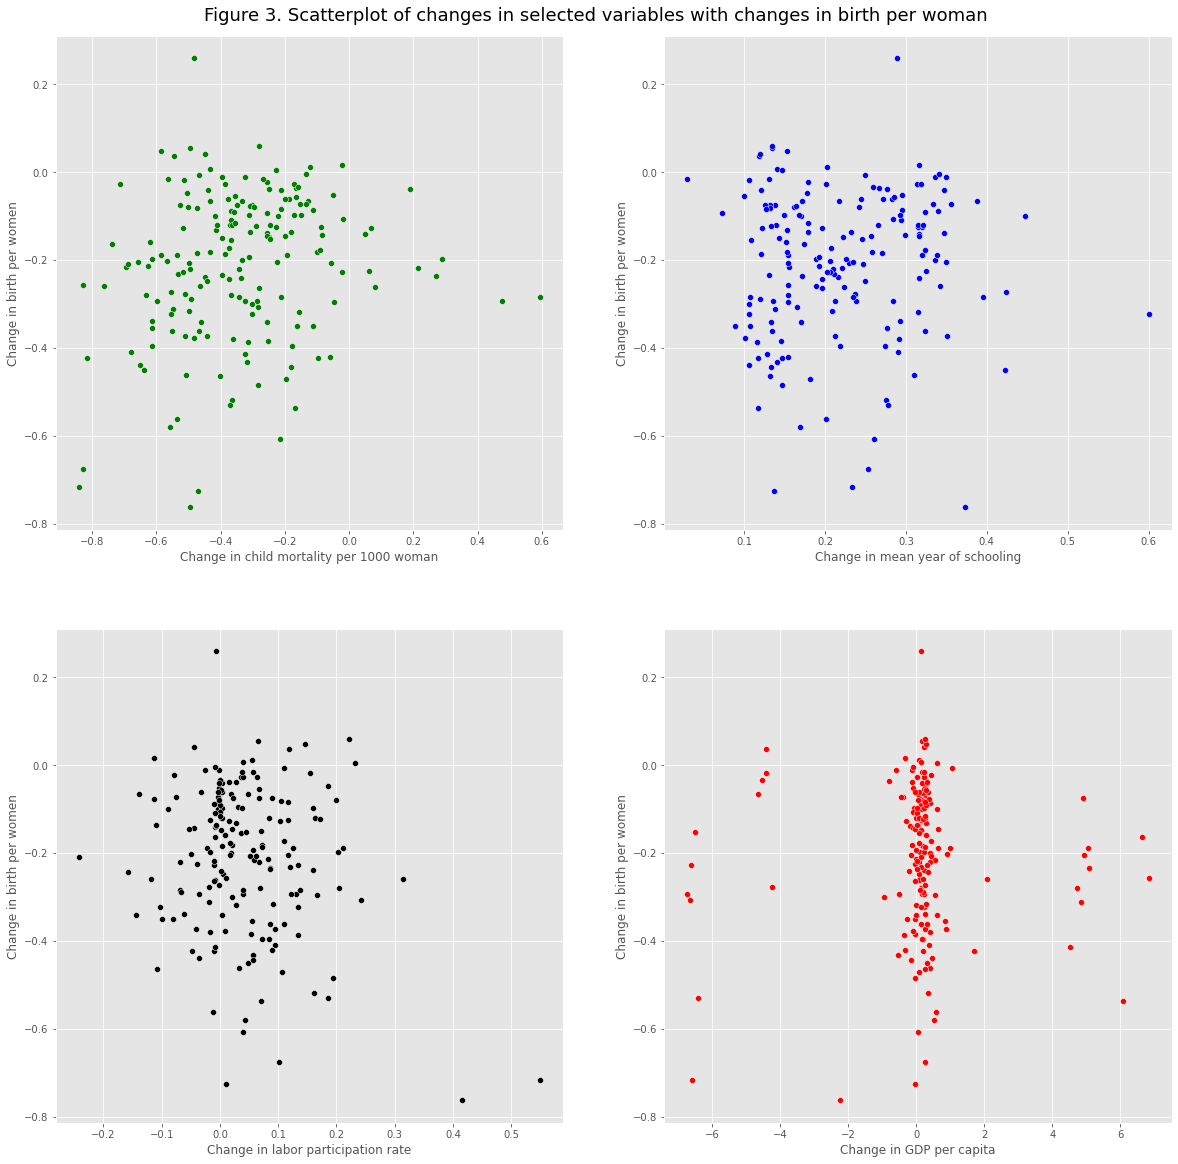

In [16]:
## Correlation of changes in birth rate with changes in respective variables
fig, axes = plt.subplots(2,2, figsize=(20,20))
fig.suptitle('Figure 3. Scatterplot of changes in selected variables with changes in birth per woman', 
             fontsize = 18, y=0.90)

sns.scatterplot(x='d_c_mrtlty', y='d_birthrt', color='green', data=df_n, ax =axes[0,0])
sns.scatterplot(x='d_schooling', y='d_birthrt', color='blue', data=df_n, ax =axes[0,1])
sns.scatterplot(x='d_lbr_prt', y='d_birthrt', color='black', data=df_n, ax =axes[1,0])
sns.scatterplot(x='d_gdppc', y='d_birthrt', color='red', data=df_n, ax =axes[1,1])

axes[0, 0].set(xlabel = 'Change in child mortality per 1000 woman', ylabel = 'Change in birth per women')
axes[0, 1].set(xlabel = 'Change in mean year of schooling', ylabel = 'Change in birth per women')
axes[1, 0].set(xlabel = 'Change in labor participation rate', ylabel = 'Change in birth per women')
axes[1, 1].set(xlabel = 'Change in GDP per capita', ylabel = 'Change in birth per women')

plt.show()

Above Figure 3, shows that previous finding on correlations is weakly continued in terms of child mortality. Countries where child mortality declined a lot also had higher declines in birth rate per woman. Other variables do not show visible correlations. Another, important aspect is correlation between changes in income and changes in birth rates. Here we see that during period 1990 and 2000, gdp per capita for most of the countries did not change much (most values are around 0). We can conclude that possibly, birth rate changes were less driven by income, since income did not change much during this period. 

### Research Question 2  (Does schooling decreases fertility?)

First look at how mean schooling shifted from 1990 to 2000. Histogram (Figure 4) below shows that many countries shifted to greater female mean scholing, however it also shows that some countries remained at low female schooling position.

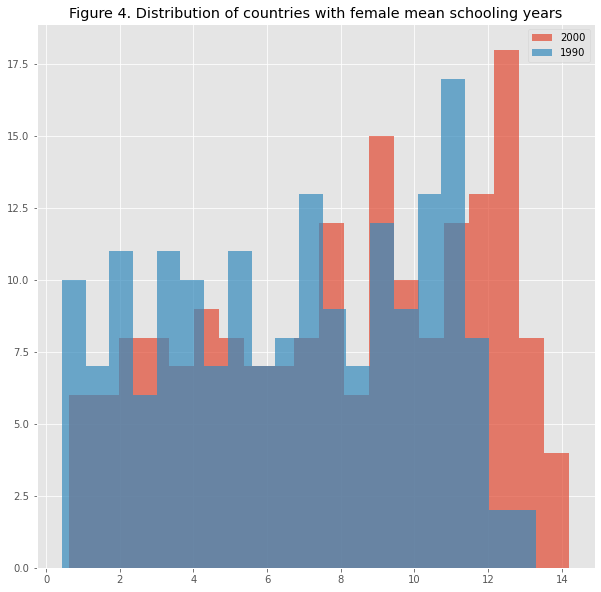

In [17]:
df_2000['schooling_2000'].hist(figsize=(10,10), alpha=0.7, bins =20, label = '2000')
df_1990['schooling_1990'].hist(figsize=(10,10), alpha=0.7, bins =20, label = '1990')
plt.title('Figure 4. Distribution of countries with female mean schooling years')
plt.legend()
plt.show()

Above scatterplot showed mixed results on schooling and birth per woman. IN fact, there are a lot of factors in the background related with schooling. For example, schooling maybe increased due to more income or schooling is needed to increase labor participation. Both not realted with fertility. So we need to isolate this impact and see whether we see any correlation when these variables are constant. How to keep other factors constant? Solutions: look at only countries where change in gdp per capita and labor participation was negligent or constant. Let's restrict decadal change to no more than 5% to consider the growth as negligent. Below code obtains country names with negligent changes in gdp per capita or labor participation.

In [18]:
#Countries with no growth in gdp per capita
no_growth_gdp = list(df_n.loc[abs(df_n.d_gdppc)<0.05, 'country'])
#countries with no growth in labor participation
no_growth_lbr_prt = list(df_n.loc[abs(df_n.d_lbr_prt)<0.05, 'country'])
print("Number of countries where gdp growth for the decade was close to 0: {}".format(len(no_growth_gdp)))
print("Number of countries where growth in female labor" + 
      " participation for the decade was close to 0: {}".format(len(no_growth_lbr_prt)))


Number of countries where gdp growth for the decade was close to 0: 21
Number of countries where growth in female labor participation for the decade was close to 0: 87


Let's plot scatter plot of decadal change in birth per woman against change in schooling for each set of countries (Figure 5).

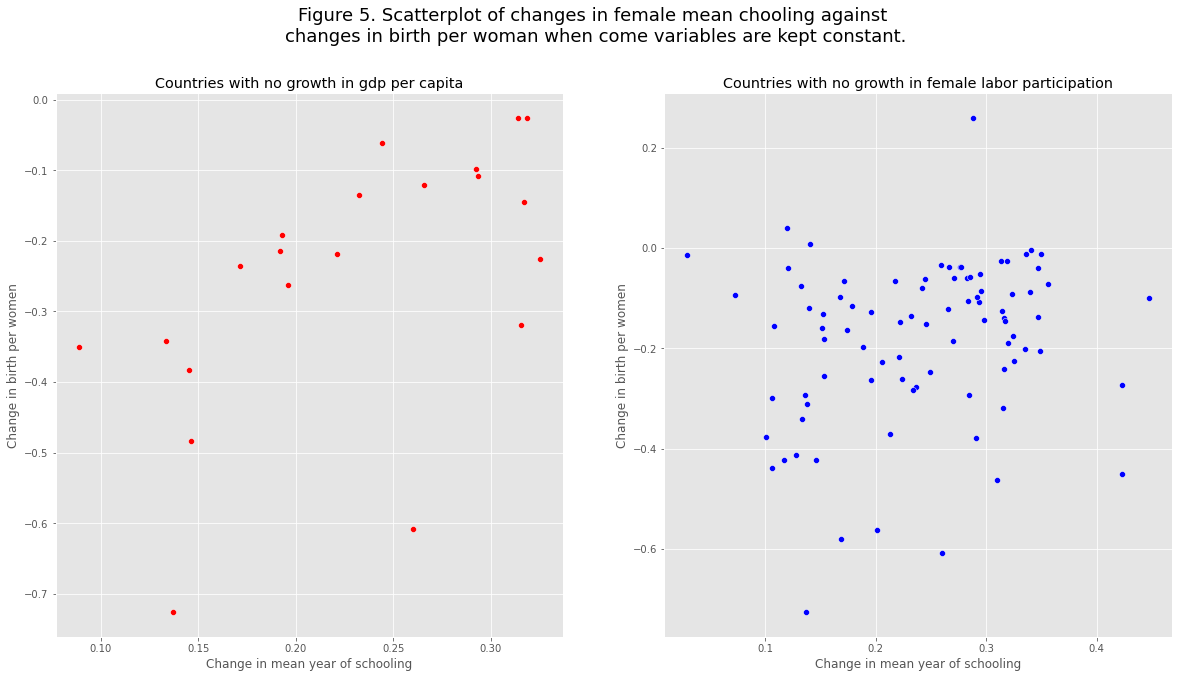

In [19]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Figure 5. Scatterplot of changes in female mean chooling against \n" + 
             "changes in birth per woman when come variables are kept constant.", 
             fontsize = 18, y=1.00)

sns.scatterplot(x='d_schooling', y='d_birthrt', color='red', data=df_n[df_n.country.isin(no_growth_gdp)], ax = axes[0])
sns.scatterplot(x='d_schooling', y='d_birthrt', color='blue', data=df_n[df_n.country.isin(no_growth_lbr_prt)], ax = axes[1])

axes[0].set(xlabel = 'Change in mean year of schooling', ylabel = 'Change in birth per women')
axes[1].set(xlabel = 'Change in mean year of schooling', ylabel = 'Change in birth per women')

axes[0].set_title("Countries with no growth in gdp per capita")
axes[1].set_title("Countries with no growth in female labor participation")

plt.show()

Above Figure 5, shows that if we look at countries where gdp per capita almost did not change within a decade, change in schooling associated positively with change in birth per woman. However, keeping labor participation constant still produced ambigious result for the correlation of changes in birth and schooling of female.

<a id='conclusions'></a>
## Conclusions

> Above exploratory analysis shows that child mortality is negatively associated with birth per woman. In fact, it indicates that recent decline in child mortality is very highly negatively correlated with recent decline in birth per woman. Birth per woman declined in countries where child mortality declined steeply.

> Schooling and birth per woman from the outer view looks negatively associated. However, further analysis of decadal percentage change showed that correlation is very ambigious.

> Other factors such as labor participation and gdp per capita do not show any plalusible association. It might be that these values were mostly constant over observed period. Analysis may need longer observation period with greater variation.

### Limitation of the analysis
> These data analysis is limited since we are not considering other factors impacting birth per woman. These have been shown when we conducted exercise on looking at relative changes in schooling and birth per woman when some varaible are kept constant. In this case correlation of schooling and birth per woman even turned to opposite sign. This is an indication that analysis needs more information on other factors.

> Using other methodology such as regressions analysis or machine learning could be plausible approach to overcome limitations.